In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import requests
from bs4 import BeautifulSoup as BS
import re
import warnings
import folium
import bokeh
from numpy import NaN
import matplotlib.pyplot as plt
import scrapy
from pybaseball import pitching_stats
from pybaseball import statcast_single_game,statcast_pitcher,pitching_stats_bref
from pybaseball import playerid_lookup
from pybaseball import statcast_pitcher
from pybaseball import schedule_and_record
import seaborn as sns


from sklearn import metrics
from sklearn.cluster import k_means,KMeans,hierarchical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix  
from tqdm import tqdm_notebook as tqdm
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

In [2]:
all_starts = pd.read_csv('all_starts.csv')

cluster_data = pd.read_csv('cluster_data.csv')

cluster_data = cluster_data.drop(columns=['Age','WAR','Pace (pi)', 'Contact% (pi)','Zone% (pi)'])

awards_players = pd.read_csv('AwardsPlayers.csv')

People = pd.read_csv('People.csv')

In [3]:
awards_players = pd.merge(awards_players,People,on='playerID')

In [4]:
awards_players_2006 = awards_players.loc[awards_players['yearID'] >= 2006]

In [5]:
cy_young = awards_players_2006.loc[awards_players_2006['awardID'] == 'Cy Young Award']

cy_young = cy_young[['playerID','awardID','yearID','lgID','nameFirst','nameLast']]

cy_young['Name'] = cy_young['nameFirst'] + ' ' + cy_young['nameLast']

cy_young = cy_young.drop(columns=['nameFirst','nameLast'])

cy_young['Winner'] = True

cy_young = cy_young.rename(columns={'yearID':'Season'})

cy_young = cy_young.drop(columns=['lgID','playerID','awardID'])

cy_young.head()

,Season,Name,Winner
5456,2010,Roy Halladay,True
5513,2006,Johan Santana,True
5626,2006,Brandon Webb,True
5638,2011,Justin Verlander,True
5708,2007,CC Sabathia,True


In [6]:
cluster_data = pd.merge(cluster_data,cy_young,how='left')

In [7]:
cluster_data = cluster_data.fillna(False)

In [8]:
cluster_data['Winner'] = cluster_data['Winner'].astype(int)

In [9]:
cluster_data = cluster_data[['Season','Name','Winner','IP','K/9','BB/9','tERA','HR/9','LOB%','FIP','GB/FB','BABIP','K%','BB%','SwStr%']]

## Cluster Time

In [10]:
cluster_data.loc[(cluster_data['Name']=='Jacob deGrom') & (cluster_data['Season'] == 2018.0),'Winner'] = 1

cluster_data.loc[(cluster_data['Name']=='Blake Snell') & (cluster_data['Season'] == 2018.0),'Winner'] = 1

cluster_data.head()

,Season,Name,Winner,IP,K/9,BB/9,tERA,HR/9,LOB%,FIP,GB/FB,BABIP,K%,BB%,SwStr%
0,2018.0,Jacob deGrom,1,217.0,11.16,1.91,2.15,0.41,0.820,1.99,1.47,0.281,0.322,0.055,0.151
1,2011.0,Roy Halladay,0,233.2,8.47,1.35,2.46,0.39,0.781,2.20,1.67,0.298,0.236,0.038,0.109
2,2015.0,Clayton Kershaw,0,232.2,11.64,1.62,2.28,0.58,0.783,1.99,1.77,0.281,0.338,0.047,0.159
3,2009.0,Zack Greinke,1,229.1,9.50,2.00,2.55,0.43,0.793,2.33,0.99,0.303,0.265,0.056,0.100
4,2009.0,Justin Verlander,0,240.0,10.09,2.36,3.18,0.75,0.727,2.80,0.84,0.319,0.274,0.064,0.114


In [11]:
X = cluster_data.iloc[:, 3:15].values  
y = cluster_data.iloc[:, :3].values 

In [12]:
X

array([[2.170e+02, 1.116e+01, 1.910e+00, ..., 3.220e-01, 5.500e-02,
        1.510e-01],
       [2.332e+02, 8.470e+00, 1.350e+00, ..., 2.360e-01, 3.800e-02,
        1.090e-01],
       [2.322e+02, 1.164e+01, 1.620e+00, ..., 3.380e-01, 4.700e-02,
        1.590e-01],
       ...,
       [1.091e+02, 4.030e+00, 3.620e+00, ..., 9.600e-02, 8.600e-02,
        5.700e-02],
       [1.990e+02, 4.880e+00, 2.040e+00, ..., 1.260e-01, 5.300e-02,
        5.900e-02],
       [4.010e+01, 6.470e+00, 6.920e+00, ..., 1.440e-01, 1.540e-01,
        6.900e-02]])

In [13]:
y

array([[2018.0, 'Jacob deGrom', 1],
       [2011.0, 'Roy Halladay', 0],
       [2015.0, 'Clayton Kershaw', 0],
       ...,
       [2010.0, 'Ryan Rowland-Smith', 0],
       [2011.0, 'Bronson Arroyo', 0],
       [2011.0, 'Scott Proctor', 0]], dtype=object)

In [14]:
scaler = StandardScaler()
 
X_scaled = scaler.fit_transform(X) 

In [15]:
kmeans = KMeans(n_clusters=1000, max_iter=1000, algorithm = 'auto')

#kmeans_messy = KMeans(n_clusters=3, max_iter=1000, algorithm = 'auto')
kmeans.fit_transform(X_scaled)

array([[ 1.83262304,  4.9286291 , 10.83326851, ..., 15.48496458,
         4.93814485,  5.45224094],
       [ 1.04218432,  3.92460888,  9.77273198, ..., 14.35897836,
         4.42739093,  4.70915006],
       [ 2.24128393,  5.3145919 , 11.03603348, ..., 15.55716232,
         5.28481816,  5.75833133],
       ...,
       [ 4.83344134,  1.86408591,  5.59431076, ..., 10.38421585,
         4.05629927,  3.99235237],
       [ 3.70367924,  2.51286105,  7.13046488, ..., 11.32198417,
         4.82302722,  4.61659237],
       [ 5.66662013,  2.76879018,  5.30875694, ..., 11.00751996,
         4.03858512,  3.89478115]])

In [16]:
#gm_messy = GaussianMixture(n_components=3).fit(X).predict(X)

#plt.scatter(X[:,11], X[:,4], c=gm_messy, cmap='plasma')

#fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
#print ("Current size:", fig_size)
 
# Set figure width to 12 and height to 9
#fig_size[0] = 12
#fig_size[1] = 9
#plt.scatter(kmeans.cluster_centers_[:,10] ,kmeans.cluster_centers_[:,3], color='black') 

In [17]:
pca = PCA(n_components=2)
X_r = pca.fit(X_scaled).transform(X_scaled)

In [18]:
X_r

array([[-3.95691831,  0.42777593],
       [-2.79953279, -1.31667761],
       [-4.17674119,  0.49385503],
       ...,
       [ 1.92378861, -1.51017552],
       [ 0.68202041, -2.19567885],
       [ 2.56005999,  0.96283566]])

In [19]:
kmeans.cluster_centers_

array([[ 2.52870603,  0.60180543, -0.68290263, ...,  0.87821452,
        -0.69991064,  0.88310676],
       [ 0.623777  , -0.31579857, -0.09460272, ..., -0.34521879,
        -0.0753013 , -0.08276199],
       [-1.00125159, -1.83917422,  1.38062866, ..., -2.04975603,
         0.5255524 , -1.47681952],
       ...,
       [-1.03792112, -2.76085632, -1.56324614, ..., -2.60835136,
        -1.98107654, -3.07226264],
       [-0.69976977,  0.42976259,  0.21717814, ...,  0.29634438,
         0.30361129,  0.1913326 ],
       [-0.58351071, -0.15663414,  0.29017503, ..., -0.23432119,
         0.38455452,  0.0812304 ]])

In [20]:
print(kmeans.labels_)

[393 459 393 ... 432 262 342]


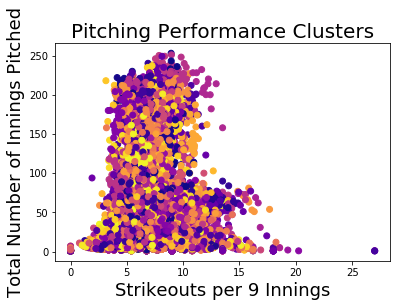

<Figure size 1440x720 with 0 Axes>

In [21]:
plt.scatter(X[:,1], X[:,0], c=kmeans.labels_, cmap='plasma')
plt.xlabel('Strikeouts per 9 Innings',fontsize=18)
plt.ylabel('Total Number of Innings Pitched',fontsize=18)
plt.title('Pitching Performance Clusters',fontsize=20)
plt.figure(figsize=(20,10))

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
#plt.scatter(kmeans.cluster_centers_[:,1] ,kmeans.cluster_centers_[:,0], color='gold') 

In [22]:
cluster_data['Cluster'] = kmeans.predict(X_scaled)

In [23]:
cluster_data.head()

,Season,Name,Winner,IP,K/9,BB/9,tERA,HR/9,LOB%,FIP,GB/FB,BABIP,K%,BB%,SwStr%,Cluster
0,2018.0,Jacob deGrom,1,217.0,11.16,1.91,2.15,0.41,0.820,1.99,1.47,0.281,0.322,0.055,0.151,393
1,2011.0,Roy Halladay,0,233.2,8.47,1.35,2.46,0.39,0.781,2.20,1.67,0.298,0.236,0.038,0.109,459
2,2015.0,Clayton Kershaw,0,232.2,11.64,1.62,2.28,0.58,0.783,1.99,1.77,0.281,0.338,0.047,0.159,393
3,2009.0,Zack Greinke,1,229.1,9.50,2.00,2.55,0.43,0.793,2.33,0.99,0.303,0.265,0.056,0.100,429
4,2009.0,Justin Verlander,0,240.0,10.09,2.36,3.18,0.75,0.727,2.80,0.84,0.319,0.274,0.064,0.114,429


In [24]:
cm = sns.light_palette("xkcd:goldenrod", as_cmap=True)

aroldis_chapman = cluster_data.loc[cluster_data['Name']=='Aroldis Chapman']

aroldis_chapman.style.background_gradient(cmap=cm)

,Season,Name,Winner,IP,K/9,BB/9,tERA,HR/9,LOB%,FIP,GB/FB,BABIP,K%,BB%,SwStr%,Cluster
502,2012,Aroldis Chapman,0,71.2,15.32,2.89,1.65,0.5,0.869,1.55,0.87,0.252,0.442,0.083,0.179,760
622,2014,Aroldis Chapman,0,54,17.67,4,1.04,0.17,0.768,0.89,1.25,0.29,0.525,0.119,0.202,760
667,2016,Aroldis Chapman,0,58,13.97,2.79,1.91,0.31,0.805,1.42,1.58,0.268,0.405,0.081,0.186,67
766,2015,Aroldis Chapman,0,66.1,15.74,4.48,2.13,0.41,0.885,1.94,0.9,0.331,0.417,0.119,0.193,760
1145,2018,Aroldis Chapman,0,51.1,16.31,5.26,2.07,0.35,0.783,2.09,1.19,0.268,0.439,0.142,0.161,760
1223,2013,Aroldis Chapman,0,63.2,15.83,4.1,2.92,0.99,0.862,2.47,0.79,0.28,0.434,0.112,0.165,760
1473,2017,Aroldis Chapman,0,50.1,12.34,3.58,2.46,0.54,0.717,2.56,1.39,0.296,0.329,0.095,0.136,22
2939,2010,Aroldis Chapman,0,13.1,12.83,3.38,1.18,0,0.714,1.35,4.75,0.333,0.373,0.098,0.149,386
3147,2011,Aroldis Chapman,0,50,12.78,7.38,3.41,0.36,0.717,3.29,1.71,0.242,0.343,0.198,0.139,421


In [44]:
len(cluster_data.loc[cluster_data['Cluster']==760])

9

In [45]:
cluster_248 = cluster_data.loc[cluster_data.Cluster == 760]

cluster_248.style.background_gradient(cmap=cm)

,Season,Name,Winner,IP,K/9,BB/9,tERA,HR/9,LOB%,FIP,GB/FB,BABIP,K%,BB%,SwStr%,Cluster,Cy_young_winner
502,2012,Aroldis Chapman,0,71.2,15.32,2.89,1.65,0.5,0.869,1.55,0.87,0.252,0.442,0.083,0.179,760,0
621,2011,Craig Kimbrel,0,77,14.84,3.74,1.46,0.35,0.807,1.52,1.12,0.315,0.415,0.105,0.158,760,0
622,2014,Aroldis Chapman,0,54,17.67,4,1.04,0.17,0.768,0.89,1.25,0.29,0.525,0.119,0.202,760,0
664,2018,Josh Hader,0,81.1,15.82,3.32,2.4,1,0.809,2.23,0.6,0.22,0.467,0.098,0.19,760,0
766,2015,Aroldis Chapman,0,66.1,15.74,4.48,2.13,0.41,0.885,1.94,0.9,0.331,0.417,0.119,0.193,760,0
1145,2018,Aroldis Chapman,0,51.1,16.31,5.26,2.07,0.35,0.783,2.09,1.19,0.268,0.439,0.142,0.161,760,0
1223,2013,Aroldis Chapman,0,63.2,15.83,4.1,2.92,0.99,0.862,2.47,0.79,0.28,0.434,0.112,0.165,760,0
1401,2011,Kenley Jansen,0,53.2,16.1,4.36,2.03,0.5,0.762,1.74,0.54,0.297,0.44,0.119,0.163,760,0
4366,2018,Daniel Zamora,0,9,16,3,1.68,1,0.814,2.38,0.75,0.333,0.444,0.083,0.146,760,0


In [46]:
winner_data = cluster_data.loc[cluster_data['Winner']==1]

winner_data.style.background_gradient(cmap=cm)

,Season,Name,Winner,IP,K/9,BB/9,tERA,HR/9,LOB%,FIP,GB/FB,BABIP,K%,BB%,SwStr%,Cluster,Cy_young_winner
0,2018,Jacob deGrom,1,217,11.16,1.91,2.15,0.41,0.82,1.99,1.47,0.281,0.322,0.055,0.151,393,1
3,2009,Zack Greinke,1,229.1,9.5,2,2.55,0.43,0.793,2.33,0.99,0.303,0.265,0.056,0.1,429,1
5,2014,Clayton Kershaw,1,198.1,10.85,1.41,1.84,0.41,0.816,1.81,1.77,0.278,0.319,0.041,0.142,132,1
7,2009,Tim Lincecum,1,225.1,10.42,2.72,2.55,0.4,0.759,2.34,1.43,0.282,0.288,0.075,0.109,429,1
8,2011,Clayton Kershaw,1,233.1,9.57,2.08,2.48,0.58,0.786,2.47,1.12,0.269,0.272,0.059,0.112,429,1
12,2017,Corey Kluber,1,203.2,11.71,1.59,2.93,0.93,0.826,2.5,1.33,0.267,0.341,0.046,0.156,393,1
13,2013,Clayton Kershaw,1,236,8.85,1.98,2.87,0.42,0.806,2.39,1.47,0.251,0.256,0.057,0.114,0,1
14,2008,Tim Lincecum,1,227,10.51,3.33,2.95,0.44,0.779,2.62,1.25,0.304,0.286,0.091,0.119,731,1
15,2014,Corey Kluber,1,235.2,10.27,1.95,2.79,0.53,0.786,2.35,1.57,0.316,0.283,0.054,0.12,429,1
17,2015,Jake Arrieta,1,229,9.28,1.89,2.77,0.39,0.8,2.35,2.47,0.246,0.271,0.055,0.111,0,1


In [47]:
Counter(winner_data.Cluster).most_common()

[(429, 8), (393, 5), (459, 4), (0, 2), (917, 2), (841, 2), (132, 1), (731, 1)]

In [48]:
Cy_young_yes = ['Jacob deGrom','Zack Greinke','Clayton Kershaw','Tim Lincecum',
 'Corey Kluber',
 'Jake Arrieta',
 'Cliff Lee',
 'Felix Hernandez',
 'Jake Peavy',
 'Johan Santana',
 'Justin Verlander',
 'Brandon Webb',
 'CC Sabathia',
 'Roy Halladay',
 'Max Scherzer',
 'Dallas Keuchel',
 'Rick Porcello',
 'Blake Snell',
 'David Price']

In [49]:
cluster_data['Cy_young_winner'] = np.where(cluster_data["Name"].isin(Cy_young_yes), 1, 0)

Counter(cluster_data.Cy_young_winner)

Counter({1: 175, 0: 8711})

In [50]:
all_cy_young_seasons = cluster_data.loc[cluster_data.Cy_young_winner == 1]

Counter(all_cy_young_seasons.Cluster).most_common();

In [51]:
print(cluster_data.loc[cluster_data['Name']=="Clayton Kershaw"])

print(cluster_data.loc[cluster_data['Cluster']==54]);

      Season             Name  Winner     IP    K/9  BB/9  tERA  HR/9   LOB%  \
2     2015.0  Clayton Kershaw       0  232.2  11.64  1.62  2.28  0.58  0.783   
5     2014.0  Clayton Kershaw       1  198.1  10.85  1.41  1.84  0.41  0.816   
8     2011.0  Clayton Kershaw       1  233.1   9.57  2.08  2.48  0.58  0.786   
13    2013.0  Clayton Kershaw       1  236.0   8.85  1.98  2.87  0.42  0.806   
37    2016.0  Clayton Kershaw       0  149.0  10.39  0.66  1.91  0.48  0.800   
43    2012.0  Clayton Kershaw       0  227.2   9.05  2.49  2.97  0.63  0.779   
174   2010.0  Clayton Kershaw       0  204.1   9.34  3.57  2.98  0.57  0.762   
194   2017.0  Clayton Kershaw       0  175.0  10.39  1.54  3.05  1.18  0.874   
242   2009.0  Clayton Kershaw       0  171.0   9.74  4.79  3.07  0.37  0.775   
424   2018.0  Clayton Kershaw       0  161.1   8.65  1.62  3.59  0.95  0.787   
1679  2008.0  Clayton Kershaw       0  107.2   8.36  4.35  4.36  0.92  0.757   

       FIP  GB/FB  BABIP     K%    BB% 

In [33]:
Counter(cluster_data.Cy_young_winner).most_common()

[(0, 8711), (1, 175)]

In [52]:
cy_young_cluster = cluster_data.loc[cluster_data['Cluster']==429]

In [53]:
print('Number of cy young seasons in this cluster:',cy_young_cluster['Winner'].sum())

print('Number of cy young winners in this cluster', cy_young_cluster['Cy_young_winner'].sum())

print('Total # of pitchers:',len(cy_young_cluster))

Number of cy young seasons in this cluster: 8
Number of cy young winners in this cluster 21
Total # of pitchers: 32


In [54]:
cy_young_cluster.sort_values(by='Winner',ascending=False).head(10)

cy_young_cluster.style.background_gradient(cmap=cm)

,Season,Name,Winner,IP,K/9,BB/9,tERA,HR/9,LOB%,FIP,GB/FB,BABIP,K%,BB%,SwStr%,Cluster,Cy_young_winner
3,2009,Zack Greinke,1,229.1,9.5,2,2.55,0.43,0.793,2.33,0.99,0.303,0.265,0.056,0.1,429,1
4,2009,Justin Verlander,0,240,10.09,2.36,3.18,0.75,0.727,2.8,0.84,0.319,0.274,0.064,0.114,429,1
7,2009,Tim Lincecum,1,225.1,10.42,2.72,2.55,0.4,0.759,2.34,1.43,0.282,0.288,0.075,0.109,429,1
8,2011,Clayton Kershaw,1,233.1,9.57,2.08,2.48,0.58,0.786,2.47,1.12,0.269,0.272,0.059,0.112,429,1
15,2014,Corey Kluber,1,235.2,10.27,1.95,2.79,0.53,0.786,2.35,1.57,0.316,0.283,0.054,0.12,429,1
20,2012,Justin Verlander,0,238.1,9.03,2.27,3.44,0.72,0.764,2.94,1.19,0.273,0.25,0.063,0.119,429,1
24,2007,Jake Peavy,1,223.1,9.67,2.74,2.46,0.52,0.783,2.84,1.13,0.273,0.267,0.076,0.11,429,1
25,2006,Johan Santana,1,233.2,9.44,1.81,3.13,0.92,0.777,3.04,1.02,0.269,0.265,0.051,0.133,429,1
26,2015,David Price,0,220.1,9.19,1.92,3.36,0.69,0.786,2.78,1.11,0.29,0.253,0.053,0.119,429,1
31,2011,Justin Verlander,1,251,8.96,2.04,3.11,0.86,0.803,2.99,0.96,0.236,0.258,0.059,0.104,429,1


In [55]:
print(cluster_data.groupby('Cluster')['Cy_young_winner'].sum().sort_values(ascending=False).head(10))

Cluster
429    21
459    16
393     9
0       7
192     6
132     5
917     5
731     5
970     5
440     5
Name: Cy_young_winner, dtype: int64


In [56]:
grouped = cluster_data.groupby('Cluster')
grouped.get_group(310);

In [72]:
cluster_731 = cluster_data.loc[cluster_data.Cluster == 731]

cluster_731 = cluster_731.sort_values(by='Season',ascending=False).head(15)

In [73]:
cluster_731.style.background_gradient(cmap=cm)

,Season,Name,Winner,IP,K/9,BB/9,tERA,HR/9,LOB%,FIP,GB/FB,BABIP,K%,BB%,SwStr%,Cluster,Cy_young_winner
221,2018,Mike Clevinger,0,200,9.32,3.02,3.85,0.95,0.798,3.52,1.03,0.28,0.256,0.083,0.12,731,0
227,2018,Zack Wheeler,0,182.1,8.84,2.71,3.26,0.69,0.746,3.25,1.25,0.279,0.241,0.074,0.107,731,0
450,2017,Carlos Martinez,0,205,9.53,3.12,3.97,1.19,0.749,3.91,1.72,0.284,0.253,0.083,0.106,731,0
531,2016,Chris Archer,0,201.1,10.42,3,3.72,1.34,0.725,3.81,1.38,0.296,0.274,0.079,0.122,731,0
524,2016,Drew Pomeranz,0,170.2,9.81,3.43,3.69,1.16,0.801,3.8,1.24,0.268,0.265,0.093,0.111,731,0
404,2016,Cole Hamels,0,200.2,8.97,3.45,4.56,1.08,0.791,3.98,1.61,0.299,0.236,0.091,0.122,731,0
2387,2015,James Shields,0,202.1,9.61,3.6,4.54,1.47,0.799,4.45,1.3,0.299,0.251,0.094,0.124,731,0
590,2014,Ian Kennedy,0,201,9.27,3.13,3.55,0.72,0.74,3.21,1.05,0.315,0.245,0.083,0.101,731,0
1524,2013,Tim Lincecum,0,197.2,8.79,3.46,4.12,0.96,0.694,3.74,1.43,0.3,0.23,0.09,0.113,731,1
145,2013,Justin Verlander,0,218.1,8.95,3.09,3.84,0.78,0.745,3.28,0.99,0.316,0.235,0.081,0.107,731,1


In [74]:
for name,group in grouped:
    print(name)
    print(group)

0
     Season               Name  Winner     IP   K/9  BB/9  tERA  HR/9   LOB%  \
10   2008.0        CC Sabathia       0  253.0  8.93  2.10  3.33  0.68  0.777   
13   2013.0    Clayton Kershaw       1  236.0  8.85  1.98  2.87  0.42  0.806   
17   2015.0       Jake Arrieta       1  229.0  9.28  1.89  2.77  0.39  0.800   
43   2012.0    Clayton Kershaw       0  227.2  9.05  2.49  2.97  0.63  0.779   
48   2010.0       Josh Johnson       0  183.2  9.11  2.35  2.83  0.34  0.792   
68   2014.0    Felix Hernandez       0  236.0  9.46  1.75  2.56  0.61  0.770   
79   2007.0        John Smoltz       0  205.2  8.62  2.06  3.34  0.79  0.762   
82   2015.0       Zack Greinke       0  222.2  8.08  1.62  2.81  0.57  0.865   
85   2018.0         Aaron Nola       0  212.1  9.49  2.46  3.13  0.72  0.825   
110  2011.0        Cole Hamels       0  216.0  8.08  1.83  2.99  0.79  0.784   
160  2012.0        R.A. Dickey       0  233.2  8.86  2.08  3.35  0.92  0.800   
161  2012.0        Cole Hamels       0

4926  3.54   0.74  0.306  0.221  0.117   0.090       25                0  
26
      Season              Name  Winner    IP   K/9  BB/9  tERA  HR/9  LOB%  \
3997  2011.0      Shawn Kelley       0  12.2  7.11  2.13  0.98  0.00   1.0   
4340  2013.0  Francisley Bueno       0   8.1  5.40  2.16  1.34  0.00   1.0   
4484  2014.0     Drake Britton       0   6.2  5.40  2.70  3.13  0.00   1.0   
4487  2018.0    J.B. Wendelken       0  16.2  7.56  2.70  2.06  0.54   1.0   
4977  2006.0       Doug Slaten       0   5.2  4.76  3.18  3.70  0.00   1.0   
4984  2010.0      Mike Hampton       0   4.1  6.23  2.08  1.42  0.00   1.0   
4985  2010.0      Steve Cishek       0   4.1  6.23  2.08  1.40  0.00   1.0   
4993  2016.0      Carlos Frias       0   4.0  6.75  2.25  1.28  0.00   1.0   
4997  2017.0     Huston Street       0   4.0  6.75  2.25  3.07  0.00   1.0   
5745  2015.0         Matt West       0   3.0  6.00  3.00  2.22  0.00   1.0   
5785  2018.0     Matt Davidson       0   3.0  6.00  3.00  5.21  

8773                0  
60
      Season       Name  Winner   IP  K/9  BB/9   tERA  HR/9  LOB%    FIP  \
7019  2014.0  Mike Carp       0  1.0  0.0  45.0  24.28   0.0   0.8  18.13   

      GB/FB  BABIP   K%    BB%  SwStr%  Cluster  Cy_young_winner  
7019    1.0    0.0  0.0  0.714     0.0       60                0  
61
      Season      Name  Winner   IP   K/9  BB/9  tERA  HR/9  LOB%   FIP  \
6035  2015.0  C.C. Lee       0  1.2  16.2   5.4  3.56   0.0   0.8  1.33   

      GB/FB  BABIP   K%  BB%  SwStr%  Cluster  Cy_young_winner  
6035    3.0  0.667  0.3  0.1   0.103       61                0  
62
      Season              Name  Winner    IP   K/9   BB/9  tERA  HR/9   LOB%  \
7117  2010.0     Daniel Stange       0   4.0  4.50  13.50  8.88  2.25  0.465   
8074  2013.0      Nick Maronde       0   5.1  8.44  13.50  9.16  1.69  0.566   
8687  2008.0  Dontrelle Willis       0  24.0  6.75  13.13  7.92  1.50  0.599   

       FIP  GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
7

93
      Season             Name  Winner   IP  K/9  BB/9  tERA  HR/9  LOB%   FIP  \
5739  2015.0     Brendan Ryan       0  2.0  0.0   0.0  6.67   0.0   1.0  3.13   
5757  2016.0  Eduardo Escobar       0  1.0  0.0   0.0  9.72   0.0   1.0  3.15   
5771  2017.0          Jon Jay       0  1.0  0.0   0.0  7.47   0.0   1.0  3.16   

      GB/FB  BABIP   K%  BB%  SwStr%  Cluster  Cy_young_winner  
5739   0.67   0.25  0.0  0.0   0.036       93                0  
5757   1.00   0.25  0.0  0.0   0.063       93                0  
5771   0.00   0.25  0.0  0.0   0.063       93                0  
94
      Season             Name  Winner    IP   K/9  BB/9  tERA  HR/9   LOB%  \
5536  2006.0     Zack Greinke       0   6.1  7.11  4.26  7.22  1.42  0.814   
5541  2008.0   Tyler Clippard       0  10.1  6.97  6.10  5.10  1.74  0.864   
6023  2014.0  Arodys Vizcaino       0   5.0  7.20  5.40  5.82  1.80  0.758   
6130  2016.0      Adam Plutko       0   3.2  7.36  4.91  5.87  2.45  0.714   
6390  2006.0       

      Season               Name  Winner    IP   K/9  BB/9  tERA  HR/9   LOB%  \
867   2010.0      Daniel Hudson       0  95.1  7.93  2.55  3.67  0.76  0.831   
1319  2006.0        Dan Wheeler       0  71.1  8.58  3.03  3.28  0.63  0.805   
1392  2012.0      Grant Balfour       0  74.2  8.68  3.38  3.42  0.48  0.761   
1534  2007.0      Russ Springer       0  66.0  9.00  2.59  2.60  0.41  0.765   
1541  2009.0       Jason Frasor       0  57.2  8.74  2.50  3.02  0.62  0.794   
1656  2008.0    Taylor Buchholz       0  66.1  7.60  2.44  3.90  0.68  0.724   
1715  2009.0       Darren O'Day       0  58.2  8.59  2.76  3.09  0.46  0.836   
1808  2009.0      Darren Oliver       0  73.0  8.01  2.71  3.05  0.62  0.815   
1830  2013.0      Michael Wacha       0  64.2  9.05  2.64  2.87  0.70  0.797   
1851  2015.0     Jerad Eickhoff       0  51.0  8.65  2.29  3.62  0.88  0.804   
1860  2010.0      Grant Balfour       0  55.1  9.11  2.77  2.70  0.49  0.789   
1943  2018.0    David Hernandez       0 

      Season             Name  Winner    IP    K/9  BB/9  tERA  HR/9   LOB%  \
4443  2015.0      Jorge Lopez       0  10.0   9.00  4.50  3.81  0.00  0.700   
4470  2016.0  Warwick Saupold       0   9.2   9.31  2.79  3.56  0.00  0.619   
5142  2013.0      Steven Ames       0   4.0   9.00  4.50  3.64  0.00  0.750   
5220  2011.0      Josh Kinney       0  17.2  10.19  3.57  4.22  0.51  0.621   
6038  2012.0       Cory Burns       0  18.0   9.00  5.00  3.89  0.50  0.730   
6099  2014.0        Matt West       0   4.0   6.75  2.25  4.19  0.00  0.571   

       FIP  GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
4443  2.93   2.83  0.467  0.217  0.109   0.096      151                0  
4470  2.32   2.71  0.486  0.204  0.061   0.111      151                0  
5142  2.55   3.50  0.462  0.211  0.105   0.118      151                0  
5220  3.03   3.88  0.431  0.247  0.086   0.127      151                0  
6038  3.65   2.69  0.403  0.196  0.109   0.152      151                

8729  6.18   1.05  0.311  0.107  0.061   0.062      187                0  
188
      Season            Name  Winner    IP    K/9  BB/9  tERA  HR/9   LOB%  \
949   2017.0    Tommy Kahnle       0  62.2  13.79  2.44  2.17  0.57  0.783   
951   2014.0   Kenley Jansen       0  65.1  13.91  2.62  2.53  0.69  0.806   
1157  2016.0      Edwin Diaz       0  51.2  15.33  2.61  2.31  0.87  0.839   
1500  2013.0    Jason Grilli       0  50.0  13.32  2.34  2.45  0.72  0.806   
3035  2017.0     A.J. Minter       0  15.0  15.60  1.20  1.40  0.60  0.735   
3582  2011.0      Matt Moore       0   9.1  14.46  2.89  2.23  0.96  0.849   
4372  2017.0  Edward Paredes       0   8.1  11.88  0.00  2.34  1.08  0.758   
5042  2013.0    Cesar Cabral       0   3.2  14.73  2.45  4.49  0.00  0.800   
5097  2011.0    Addison Reed       0   7.1  14.73  1.23  3.78  1.23  0.833   

       FIP  GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
949   1.83   1.08  0.358  0.375  0.066   0.167      188          

8475                0  
221
      Season             Name  Winner    IP    K/9  BB/9  tERA  HR/9   LOB%  \
1061  2013.0       Nate Jones       0  78.0  10.27  3.00  3.11  0.58  0.629   
1683  2016.0     Shane Greene       0  60.1   8.80  3.28  3.50  0.45  0.564   
1933  2009.0     Kevin Jepsen       0  54.2   7.90  3.13  2.79  0.33  0.619   
1971  2016.0    Justin Wilson       0  58.2   9.97  2.61  2.97  0.92  0.708   
2018  2009.0    Joel Hanrahan       0  64.0  10.13  4.78  3.83  0.42  0.662   
2330  2016.0    Xavier Cedeno       0  41.1   9.36  2.83  3.31  0.44  0.693   
2467  2015.0    Daniel Hudson       0  67.2   9.44  3.33  4.06  0.93  0.694   
2557  2018.0        Ken Giles       0  50.1   9.48  1.25  3.25  1.07  0.634   
2705  2013.0      Josh Outman       0  54.0   8.83  3.83  4.42  0.50  0.707   
2930  2018.0      Luis Garcia       0  46.0   9.98  3.52  4.10  0.78  0.612   
2987  2018.0   Matt Shoemaker       0  31.0   9.58  2.90  3.77  0.87  0.643   
2989  2017.0    Tony Bar

2559  4.15   1.53  0.263  0.173  0.088   0.085      278                0  
279
      Season               Name  Winner   IP   K/9  BB/9   tERA  HR/9   LOB%  \
8168  2010.0     Armando Gabino       0  4.2  3.86  5.79   9.12  5.79  0.641   
8170  2017.0  Richard Rodriguez       0  5.2  4.76  4.76  11.57  6.35  0.673   
8422  2016.0         David Huff       0  5.1  5.06  3.38  13.09  6.75  0.532   
8430  2015.0        Donnie Veal       0  4.1  6.23  4.15  12.38  6.23  0.588   

        FIP  GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
8168  12.51   0.82  0.333  0.077  0.115   0.080      279                0  
8170  13.39   1.10  0.400  0.097  0.097   0.067      279                0  
8422  12.90   2.17  0.391  0.094  0.063   0.056      279                0  
8430  12.83   0.75  0.333  0.125  0.083   0.071      279                0  
280
      Season           Name  Winner   IP  K/9  BB/9  tERA  HR/9   LOB%   FIP  \
6290  2006.0   Jason Bulger       0  1.2  5.4  16.2  7.2

      Season             Name  Winner     IP   K/9  BB/9  tERA  HR/9   LOB%  \
1946  2014.0       T.J. House       0  102.0  7.06  1.94  4.41  0.88  0.789   
2286  2016.0     Alex Claudio       0   51.2  5.92  1.74  3.32  0.35  0.744   
2314  2016.0  Jeremy Jeffress       0   58.0  6.52  2.79  4.31  0.31  0.809   
2679  2010.0        Ryan Webb       0   59.0  6.71  2.90  3.18  0.15  0.763   
2968  2009.0       Tim Hudson       0   42.1  6.38  2.76  3.98  0.85  0.798   
3414  2015.0    Jake Petricka       0   52.0  5.71  3.12  3.71  0.35  0.748   
3662  2008.0     Cla Meredith       0   70.1  6.27  3.07  3.61  0.77  0.732   
3781  2014.0        Sam Dyson       0   42.0  7.07  3.21  3.45  0.21  0.781   
4029  2006.0    Scott Feldman       0   41.1  6.53  2.18  4.88  0.87  0.734   
4146  2009.0     Cla Meredith       0   65.1  5.10  3.44  3.98  0.55  0.737   
4374  2012.0      Cody Eppley       0   46.0  6.26  3.33  4.40  0.59  0.748   
4439  2016.0   German Marquez       0   20.2  6.53  

      Season              Name  Winner   IP  K/9  BB/9  tERA  HR/9   LOB%  \
5731  2014.0     Stephen Pryor       0  1.2  5.4  10.8  5.97   0.0  0.667   
5957  2008.0  Humberto Sanchez       0  2.0  4.5   9.0  6.18   0.0  0.667   

       FIP  GB/FB  BABIP     K%   BB%  SwStr%  Cluster  Cy_young_winner  
5731  5.53    3.0    0.2  0.125  0.25   0.057      348                0  
5957  5.13    3.0    0.2  0.125  0.25   0.000      348                0  
349
      Season                 Name  Winner     IP   K/9  BB/9  tERA  HR/9  \
882   2008.0           Doug Davis       0  146.0  6.90  3.95  4.91  0.80   
929   2008.0            Ian Snell       0  164.1  7.39  4.87  5.31  0.99   
985   2013.0         Juan Nicasio       0  157.2  6.79  3.65  5.55  0.97   
999   2009.0       Jose Contreras       0  131.2  7.25  3.62  4.27  0.89   
1127  2012.0         Vance Worley       0  133.0  7.24  3.18  4.71  0.81   
1215  2016.0  Christian Friedrich       0  129.1  6.96  3.62  4.04  0.90   
1348  2009

      Season          Name  Winner   IP   K/9  BB/9  tERA  HR/9   LOB%   FIP  \
5122  2006.0  Travis Smith       0  4.1  2.08  2.08  3.89   0.0  0.333  3.38   
5933  2010.0      Jon Link       0  8.2  4.15  4.15  6.16   0.0  0.563  3.54   

      GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
5122   5.50  0.294  0.053  0.053   0.058      397                0  
5933   5.67  0.375  0.100  0.100   0.058      397                0  
398
      Season             Name  Winner   IP  K/9  BB/9  tERA  HR/9  LOB%   FIP  \
5646  2007.0       Jon Adkins       0  1.0  0.0   0.0  5.74   0.0   1.0  3.24   
5721  2014.0   Mitch Moreland       0  1.0  0.0   0.0  6.15   0.0   1.0  3.13   
5729  2014.0  David Carpenter       0  3.0  0.0   0.0  4.35   0.0   1.0  5.13   

      GB/FB  BABIP   K%  BB%  SwStr%  Cluster  Cy_young_winner  
5646   1.00    0.0  0.0  0.0     0.0      398                0  
5721   1.00    0.0  0.0  0.0     0.0      398                0  
5729   1.25    0.1  0.0  0.0

      Season            Name  Winner   IP   K/9  BB/9  tERA  HR/9   LOB%  \
7481  2016.0  Tom Gorzelanny       0  3.0  12.0  15.0  9.76   3.0  0.263   

       FIP  GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
7481  9.81    2.5  0.375  0.222  0.278   0.097      461                0  
462
      Season            Name  Winner   IP   K/9   BB/9  tERA  HR/9   LOB%  \
5905  2016.0  William Cuevas       0  5.0  5.40  10.80  7.93  0.00  0.818   
6838  2017.0  Jandel Gustave       0  5.0  3.60  12.60  4.46  0.00  0.667   
7077  2011.0     Rob Delaney       0  5.0  5.40  12.60  5.70  0.00  0.455   
8104  2012.0      Kerry Wood       0  8.2  6.23  11.42  7.14  1.04  0.625   

       FIP  GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
5905  5.55   0.50  0.333  0.125  0.250   0.082      462                0  
6838  6.56   1.14  0.313  0.080  0.280   0.073      462                0  
7077  6.03   0.33  0.267  0.120  0.280   0.073      462                0  
8104  7

      Season         Name  Winner   IP  K/9  BB/9  tERA  HR/9   LOB%    FIP  \
7750  2017.0  Aaron Blair       0  3.0  9.0  15.0  8.81   3.0  0.581  10.49   

      GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
7750   1.25    0.4  0.158  0.263     0.2      516                0  
517
      Season            Name  Winner    IP   K/9  BB/9  tERA  HR/9   LOB%  \
5477  2014.0   Curtis Partch       0   7.0  7.71  9.00  4.34  0.00  1.000   
5809  2018.0  Justin Hancock       0  12.1  8.03  6.57  4.80  0.73  0.952   
6687  2013.0     Zac Rosscup       0   6.2  9.45  9.45  5.75  1.35  1.000   

       FIP  GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
5477  4.42   1.00  0.118  0.200  0.233   0.070      517                0  
5809  4.62   1.00  0.143  0.225  0.184   0.068      517                0  
6687  6.05   0.18  0.133  0.233  0.233   0.110      517                0  
518
      Season            Name  Winner   IP   K/9  BB/9  tERA  HR/9  LOB%   FIP  \
6276 

      Season            Name  Winner    IP    K/9  BB/9  tERA  HR/9   LOB%  \
3203  2018.0     Sergio Romo       0  67.1  10.02  2.67  3.93  1.47  0.782   
3247  2017.0   Heath Hembree       0  62.0  10.16  2.61  4.27  1.45  0.805   
3260  2017.0    Nathan Karns       0  45.1  10.13  2.58  4.03  1.79  0.807   
3417  2016.0    Nick Vincent       0  60.1   9.70  2.24  4.05  1.64  0.802   
3603  2011.0   Huston Street       0  58.1   8.49  1.39  5.39  1.54  0.759   
3605  2016.0     Brett Cecil       0  36.2  11.05  1.96  4.58  1.47  0.788   
3607  2009.0   Russ Springer       0  57.0   9.16  2.68  3.72  1.42  0.804   
3869  2015.0      Jumbo Diaz       0  60.1  10.44  2.69  4.22  1.34  0.753   
4073  2018.0  Caleb Ferguson       0  49.0  10.84  2.20  4.29  1.47  0.791   
4210  2016.0  Junichi Tazawa       0  49.2   9.79  2.54  4.43  1.63  0.790   
4409  2017.0   Chris Hatcher       0  59.2   9.50  3.17  4.29  1.51  0.769   
4419  2018.0   Dominic Leone       0  24.0   9.75  3.00  5.18  1

      Season         Name  Winner   IP   K/9  BB/9  tERA  HR/9  LOB%   FIP  \
5880  2006.0  Colby Lewis       0  3.0  15.0   3.0  5.43   3.0   1.0  5.15   

      GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
5880    3.5  0.636  0.278  0.056   0.066      610                0  
611
      Season              Name  Winner    IP   K/9  BB/9  tERA  HR/9   LOB%  \
2531  2016.0    Daniel Mengden       0  72.0  8.88  4.13  4.88  1.13  0.615   
3559  2013.0      Josh Johnson       0  81.1  9.18  3.32  5.44  1.66  0.633   
3562  2008.0     Clay Buchholz       0  76.0  8.53  4.86  5.29  1.30  0.605   
3638  2007.0       J.P. Howell       0  51.0  8.65  3.71  5.13  1.41  0.587   
3779  2006.0       Kyle Snyder       0  60.1  8.50  2.98  5.95  1.79  0.629   
3827  2014.0        Trevor May       0  45.2  8.67  4.34  5.17  1.38  0.574   
5158  2016.0     Steven Brault       0  33.1  7.83  4.59  5.88  1.35  0.667   
5322  2017.0      Wily Peralta       0  57.1  8.16  5.02  5.81  1.57 

7589                0  
646
      Season             Name  Winner    IP   K/9  BB/9  tERA  HR/9   LOB%  \
2767  2014.0    Chris Bassitt       0  29.2  6.37  3.94  4.41  0.00  0.740   
3937  2008.0      A.J. Murray       0   7.2  5.87  3.52  4.02  0.00  0.733   
4207  2007.0      Ryan Speier       0  18.0  6.50  4.00  5.66  0.50  0.761   
4525  2008.0    Ty Taubenheim       0   6.0  6.00  4.50  6.72  0.00  0.800   
5062  2013.0   Charles Brewer       0   6.0  7.50  3.00  3.48  0.00  0.800   
5088  2018.0   Taijuan Walker       0  13.0  6.23  3.46  5.40  0.69  0.807   
5118  2015.0  Anthony Varvaro       0  11.0  6.55  4.91  4.78  0.00  0.750   
5900  2008.0  Randy Messenger       0  12.2  4.97  3.55  5.23  0.71  0.825   
5970  2017.0       T.J. House       0   2.0  4.50  4.50  8.15  0.00  0.750   
6065  2016.0   Sam Tuivailala       0   9.0  7.00  6.00  5.03  0.00  0.700   

       FIP  GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
2767  3.33   1.19  0.340  0.153  0.095

717
      Season       Name  Winner   IP  K/9  BB/9  tERA  HR/9  LOB%   FIP  \
5747  2015.0  Ike Davis       0  2.0  4.5   4.5  5.94   0.0   1.0  3.63   

      GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
5747    3.0  0.167  0.125  0.125   0.231      717                0  
718
      Season          Name  Winner   IP  K/9  BB/9  tERA  HR/9  LOB%   FIP  \
4992  2015.0  Donovan Hand       0  3.0  9.0   3.0  4.13   0.0   1.0  3.13   
5788  2018.0      Ian Krol       0  2.0  9.0   4.5  1.32   0.0   1.0  2.66   

      GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
4992    5.0   0.25  0.231  0.077   0.136      718                0  
5788    4.0   0.20  0.250  0.125   0.129      718                0  
719
      Season               Name  Winner     IP   K/9  BB/9  tERA  HR/9   LOB%  \
1002  2010.0        Travis Wood       0  102.2  7.54  2.28  3.85  0.79  0.684   
2106  2007.0        Phil Hughes       0   72.2  7.18  3.59  4.20  0.99  0.668   
2331  2012.0  

7267  4.43   1.65  0.354  0.195  0.076   0.113      772                0  
773
      Season                 Name  Winner     IP    K/9  BB/9  tERA  HR/9  \
178   2008.0          Rich Harden       0  148.0  11.01  3.71  3.09  0.67   
818   2006.0  Francisco Rodriguez       0   73.0  12.08  3.45  2.33  0.74   
1206  2011.0         Greg Holland       0   60.0  11.10  2.85  2.28  0.45   
1237  2009.0           Joe Nathan       0   68.2  11.67  2.88  2.30  0.92   
1243  2017.0            Ken Giles       0   62.2  11.92  3.02  2.29  0.57   
1266  2016.0           Brad Brach       0   79.0  10.48  2.85  3.18  0.80   
1307  2007.0        Carlos Marmol       0   69.1  12.46  4.54  2.50  0.39   
1403  2011.0       Vinnie Pestano       0   62.0  12.19  3.48  2.69  0.73   
1485  2017.0        Dominic Leone       0   70.1  10.36  2.94  2.86  0.77   
1640  2017.0       Chris Devenski       0   80.2  11.16  2.90  3.09  1.23   
1692  2016.0         Hector Neris       0   80.1  11.43  3.36  3.86  1.01 

6762  5.90   0.75  0.286  0.116  0.0   0.071      826                0  
827
      Season             Name  Winner    IP    K/9  BB/9  tERA  HR/9   LOB%  \
5399  2014.0    Dylan Axelrod       0  18.1   9.82  1.96  6.74  2.45  1.000   
6721  2010.0    Samuel Deduno       0   2.2  10.13  3.38  8.71  3.38  1.000   
6722  2012.0      Jose Ortega       0   2.2  13.50  3.38  5.21  3.38  1.000   
8037  2018.0        Luke Bard       0  11.2  10.03  3.86  6.98  3.09  0.887   
8353  2012.0  Tyler Thornburg       0  22.0   8.18  2.86  7.62  3.27  1.000   
8544  2011.0     Darren O'Day       0  16.2   9.72  2.70  7.99  3.78  0.986   

       FIP  GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
5399  5.15   0.83  0.209  0.278  0.056   0.116      827                0  
6721  6.83   1.00  0.286  0.250  0.083   0.120      827                0  
6722  6.09   0.75  0.286  0.308  0.077   0.115      827                0  
8037  7.45   0.63  0.214  0.245  0.094   0.099      827              

      Season                Name  Winner    IP   K/9  BB/9  tERA  HR/9   LOB%  \
4662  2018.0       Louis Coleman       0  51.1  7.19  4.21  5.43  0.88  0.788   
6367  2018.0       Nick Tropeano       0  76.0  7.58  3.67  5.86  1.89  0.763   
6574  2017.0     Shawn Armstrong       0  24.2  7.30  3.65  5.47  1.82  0.815   
6791  2017.0          Luis Cessa       0  36.0  7.50  4.25  5.78  1.75  0.758   
6829  2018.0     Jimmy Yacabonis       0  40.0  7.43  4.05  5.77  1.80  0.734   
7336  2016.0       Brock Stewart       0  28.0  8.04  3.86  4.78  2.25  0.767   
7359  2016.0          Jumbo Diaz       0  43.0  7.74  3.98  5.09  1.67  0.804   
7828  2006.0      Guillermo Mota       0  55.2  7.44  3.88  5.13  1.78  0.786   
7849  2016.0       Josh A. Smith       0  59.2  7.24  3.92  5.30  1.66  0.758   
7853  2007.0  Justin Duchscherer       0  16.1  7.16  4.41  5.20  1.65  0.780   
7864  2016.0        Jeff Manship       0  43.1  7.48  4.57  4.73  1.45  0.805   
8241  2009.0           Ron M

8831   9.90   0.76  0.333  0.155  0.124   0.099      940                0  
941
      Season           Name  Winner   IP    K/9  BB/9  tERA  HR/9  LOB%   FIP  \
4495  2018.0     Brad Wieck       0  7.0  12.86   0.0  1.59  1.29   1.0  2.16   
4996  2016.0  Jayson Aquino       0  2.1  11.57   0.0  1.64  0.00   1.0  0.58   

      GB/FB  BABIP     K%  BB%  SwStr%  Cluster  Cy_young_winner  
4495    0.5  0.154  0.417  0.0   0.129      941                0  
4996    0.0  0.200  0.375  0.0   0.156      941                0  
942
      Season         Name  Winner   IP    K/9  BB/9  tERA  HR/9  LOB%   FIP  \
4981  2008.0  Josh Kinney       0  7.0  10.29  1.29  0.55   0.0   1.0  1.27   

      GB/FB  BABIP    K%   BB%  SwStr%  Cluster  Cy_young_winner  
4981    4.0  0.188  0.32  0.04   0.138      942                0  
943
      Season                 Name  Winner     IP    K/9  BB/9  tERA  HR/9  \
571   2017.0  Lance McCullers Jr.       0  118.2  10.01  3.03  3.27  0.61   
1066  2016.0       J

      Season         Name  Winner   IP   K/9  BB/9  tERA  HR/9   LOB%   FIP  \
6714  2018.0  Jesus Reyes       0  5.2  3.18  3.18  6.71  1.59  0.536  6.34   

      GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
6714    3.0  0.167  0.083  0.083   0.101      974                0  
975
      Season             Name  Winner    IP   K/9   BB/9  tERA  HR/9   LOB%  \
5963  2014.0    Hector Ambriz       0   2.0  4.50   9.00  9.20  0.00  0.500   
6157  2011.0  Jordan Norberto       0   6.2  5.40   9.45  6.92  0.00  0.625   
6162  2009.0    Graham Taylor       0  11.0  4.09   9.82  6.76  0.00  0.517   
6676  2016.0     Chris Heston       0   5.0  5.40  10.80  4.22  0.00  0.600   
7674  2018.0        Mike Dunn       0  17.0  6.35   9.53  7.56  0.53  0.596   

       FIP  GB/FB  BABIP     K%    BB%  SwStr%  Cluster  Cy_young_winner  
5963  5.13   0.50  0.333  0.111  0.222   0.121      975                0  
6157  5.43   1.29  0.348  0.114  0.200   0.100      975                0  

In [75]:
sorted(grouped,key=lambda x: len(x),reverse=True)
                  # sort by number of rows (len of subDataFrame)
                

[(0,
       Season               Name  Winner     IP   K/9  BB/9  tERA  HR/9   LOB%  \
  10   2008.0        CC Sabathia       0  253.0  8.93  2.10  3.33  0.68  0.777   
  13   2013.0    Clayton Kershaw       1  236.0  8.85  1.98  2.87  0.42  0.806   
  17   2015.0       Jake Arrieta       1  229.0  9.28  1.89  2.77  0.39  0.800   
  43   2012.0    Clayton Kershaw       0  227.2  9.05  2.49  2.97  0.63  0.779   
  48   2010.0       Josh Johnson       0  183.2  9.11  2.35  2.83  0.34  0.792   
  68   2014.0    Felix Hernandez       0  236.0  9.46  1.75  2.56  0.61  0.770   
  79   2007.0        John Smoltz       0  205.2  8.62  2.06  3.34  0.79  0.762   
  82   2015.0       Zack Greinke       0  222.2  8.08  1.62  2.81  0.57  0.865   
  85   2018.0         Aaron Nola       0  212.1  9.49  2.46  3.13  0.72  0.825   
  110  2011.0        Cole Hamels       0  216.0  8.08  1.83  2.99  0.79  0.784   
  160  2012.0        R.A. Dickey       0  233.2  8.86  2.08  3.35  0.92  0.800   
  161  2012

In [76]:
#Sum_of_squared_distances = []
#K = range(1,100)
#for k in tqdm(K):
#    km = KMeans(n_clusters=k)
#    km = km.fit(X)
#    Sum_of_squared_distances.append(km.inertia_)